# Information Retrieval Evaluation With BEIR Benchmark and LangChain and MongoDB


---



# **Step 1: Install Libraires and Set Environment Variables**

In [ ]:
!pip install -q openai pymongo langchain langchain_mongodb langchain_openai beir

In [ ]:
import os
import json
import getpass

OPENAI_API_KEY = getpass.getpass("Enter OpenAI API Key: ")
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

GPT_MODEL = "gpt-4o-2024-08-06"

# Areas for optimisation of RAG Pipelines associated with chunking strategy
EMBEDDING_MODEL = "text-embedding-3-small"
EMBEDDING_DIMENSION_SIZE = 256

Enter OpenAI API Key: ··········


In [ ]:
MONGO_URI = getpass.getpass("Enter MongoDB URI: ")
os.environ["MONGO_URI"] = MONGO_URI

Enter MongoDB URI: ··········


In [ ]:
metric_names = ["NDCG", "MAP", "Recall", "Precision"]
information_retrieval_search_methods = ['Lexical', 'Vector', 'Hybrid']

# **Step 2: Data Loading**

In [ ]:
from beir import util, LoggingHandler
from beir.datasets.data_loader import GenericDataLoader
from beir.retrieval.evaluation import EvaluateRetrieval
import pandas as pd

# Load BEIR dataset
def load_beir_dataset(dataset_name="scifact"):
    url = f"https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/{dataset_name}.zip"
    data_path = util.download_and_unzip(url, "datasets")
    corpus, queries, qrels = GenericDataLoader(data_folder=data_path).load(split="test")
    return corpus, queries, qrels

/usr/local/lib/python3.10/dist-packages/beir/util.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
DATASET = "scifact"
corpus, queries, qrels = load_beir_dataset("scifact")

datasets/scifact.zip:   0%|          | 0.00/2.69M [00:00<?, ?iB/s]

  0%|          | 0/5183 [00:00<?, ?it/s]

In [ ]:
# print the first item in the corpus
print(list(corpus.items())[0])
print()
# print the first item in the queries
print(list(queries.items())[0])
print()
# print the first item in the qrels
print(list(qrels.items())[0])

('4983', {'text': 'Alterations of the architecture of cerebral white matter in the developing human brain can affect cortical development and result in functional disabilities. A line scan diffusion-weighted magnetic resonance imaging (MRI) sequence with diffusion tensor analysis was applied to measure the apparent diffusion coefficient, to calculate relative anisotropy, and to delineate three-dimensional fiber architecture in cerebral white matter in preterm (n = 17) and full-term infants (n = 7). To assess effects of prematurity on cerebral white matter development, early gestation preterm infants (n = 10) were studied a second time at term. In the central white matter the mean apparent diffusion coefficient at 28 wk was high, 1.8 microm2/ms, and decreased toward term to 1.2 microm2/ms. In the posterior limb of the internal capsule, the mean apparent diffusion coefficients at both times were similar (1.2 versus 1.1 microm2/ms). Relative anisotropy was higher the closer birth was to t

Corpus:
The corpus is a dictionary where each key is a document ID, and the value is another dictionary containing the document's text and title. For example:

```
'4983': {
    'text': 'Alterations of the architecture of cerebral white matter...',
    'title': 'Microstructural development of human newborn cerebral white matter...'
}
```


This corresponds to the scientific abstracts in our earlier example.

Queries:
The queries dictionary contains the scientific claims, where the key is a query ID and the value is the claim text. For example:

```
'1': '0-dimensional biomaterials show inductive properties.'
```

Qrels:
The qrels (query relevance) dictionary contains the ground truth relevance judgments. It's structured as a nested dictionary where the outer key is the query ID, the inner key is a document ID, and the value is the relevance score (typically 1 for relevant, 0 for non-relevant). For example:

```
'1': {'31715818': 1}
```
This indicates that for query '1', the document with ID '31715818' is relevant.

# **Step 3: Data Ingestion**

In [ ]:
# MongoDB and OpenAI configuration
MONGO_URI = os.getenv("MONGO_URI")
DB_NAME = "information_retrieval_testing"
CORPUS_COLLECTION_NAME = f"{DATASET}_corpus"
QUERIES_COLLECTION_NAME = f"{DATASET}_queries"
QRELS_COLLECTION_NAME = f"{DATASET}_qrels"
ATLAS_VECTOR_SEARCH_INDEX = "vector_index"
TEXT_SEARCH_INDEX = "text_search_index"

In [ ]:
import pymongo

def get_mongo_client(mongo_uri):
  """Establish and validate connection to the MongoDB."""

  client = pymongo.MongoClient(mongo_uri, appname="devrel.showcase.information_retrieval_eval.python")

  # Validate the connection
  ping_result = client.admin.command('ping')
  if ping_result.get('ok') == 1.0:
    # Connection successful
    print("Connection to MongoDB successful")
    return client
  else:
    print("Connection to MongoDB failed")
  return None

if not MONGO_URI:
  print("MONGO_URI not set in environment variables")

In [ ]:
def ingest_data(db, corpus=None, corpus_collection_name="", queries=None, qrels=None):
  """Ingest data into MongoDB collections."""
  # Ingest corpus
  if corpus and corpus_collection_name:
    corpus_docs = [{"_id": doc_id, "text": doc["text"], "title": doc["title"]} for doc_id, doc in corpus.items()]
    db[corpus_collection_name].insert_many(corpus_docs)
    print(f"Ingested {len(corpus_docs)} documents into {corpus_collection_name}")

  # Ingest queries
  if queries:
    query_docs = [{"_id": query_id, "text": query_text} for query_id, query_text in queries.items()]
    db[QUERIES_COLLECTION_NAME].insert_many(query_docs)
    print(f"Ingested {len(query_docs)} queries into {QUERIES_COLLECTION_NAME}")

  # Ingest qrels
  if qrels:
    qrel_docs = [{"query_id": query_id, "doc_id": doc_id, "relevance": relevance}
                  for query_id, relevance_dict in qrels.items()
                  for doc_id, relevance in relevance_dict.items()]
    db[QRELS_COLLECTION_NAME].insert_many(qrel_docs)
    print(f"Ingested {len(qrel_docs)} relevance judgments into {QRELS_COLLECTION_NAME}")

In [ ]:
# Programmatically create vector search index for both colelctions
import time
from pymongo.operations import SearchIndexModel

def setup_vector_search_index_with_filter(collection, index_definition, index_name="vector_index"):
  """
  Setup a vector search index for a MongoDB collection.

  Args:
  collection: MongoDB collection object
  index_definition: Dictionary containing the index definition
  index_name: Name of the index (default: "vector_index_with_filter")
  """
  new_vector_search_index_model = SearchIndexModel(
      definition=index_definition,
      name=index_name,
  )

  # Create the new index
  try:
    result = collection.create_search_index(model=new_vector_search_index_model)
    print(f"Creating index '{index_name}'...")
    # time.sleep(20)  # Sleep for 20 seconds
    print(f"New index '{index_name}' created successfully:", result)
  except Exception as e:
    print(f"Error creating new vector search index '{index_name}': {str(e)}")


def create_collection_search_index(collection, index_definition, index_name):
  """
  Create a search index for a MongoDB Atlas collection.

  Args:
  collection: MongoDB collection object
  index_definition: Dictionary defining the index mappings
  index_name: String name for the index

  Returns:
  str: Result of the index creation operation
  """

  try:
    search_index_model = SearchIndexModel(
        definition=index_definition,
        name=index_name
    )

    result = collection.create_search_index(model=search_index_model)
    print(f"Search index '{index_name}' created successfully")
    return result
  except Exception as e:
    print(f"Error creating search index: {str(e)}")
    return None


def print_collection_search_indexes(collection):
  """
  Print all search indexes for a given collection.

  Args:
  collection: MongoDB collection object
  """
  print(f"\nSearch indexes for collection '{collection.name}':")
  for index in collection.list_search_indexes():
      print(f"Index: {index['name']}")

In [ ]:
corpus_text_index_definition = {
  "mappings": {
    "dynamic": True,
    "fields": {
      "text": {
        "type": "string"
      },
      "title":{
        "type": "string"
      }
    }
  }
}

In [ ]:
corpus_vector_search_index_definition = {
    "mappings": {
        "dynamic": True,
        "fields": {
            "embedding": {
                "dimensions": 256,
                "similarity": "cosine",
                "type": "knnVector",
            },
        }
    }
}

In [ ]:
mongo_client = get_mongo_client(MONGO_URI)

if mongo_client:
  db = mongo_client[DB_NAME]

Connection to MongoDB successful


In [ ]:
# Clear existing collections
for collection in [CORPUS_COLLECTION_NAME, QUERIES_COLLECTION_NAME, QRELS_COLLECTION_NAME]:
  db[collection].delete_many({})

Connection to MongoDB successful
Ingested 5183 documents into scifact_corpus
Ingested 300 queries into scifact_queries
Ingested 339 relevance judgments into scifact_qrels
Error creating search index: Duplicate Index, full error: {'ok': 0.0, 'errmsg': 'Duplicate Index', 'code': 68, 'codeName': 'IndexAlreadyExists', '$clusterTime': {'clusterTime': Timestamp(1726576877, 639), 'signature': {'hash': b'VS\x0eI\x1a}\x85Gw\xc1G\x8d\xa0\xec\x13\xd2s\xe4Q\x8a', 'keyId': 7353740577831124994}}, 'operationTime': Timestamp(1726576877, 639)}

Search indexes for collection 'scifact_corpus':
Index: text_search_index


In [ ]:
# Ingest data
ingest_data(db, corpus, CORPUS_COLLECTION_NAME queries, qrels)

In [ ]:
# Create Search Index for corpus collection
create_collection_search_index(db[CORPUS_COLLECTION_NAME], corpus_text_index_definition, TEXT_SEARCH_INDEX)

In [ ]:
# Create Vector Search Index for corpus collection
setup_vector_search_index_with_filter(db[CORPUS_COLLECTION_NAME], corpus_vector_search_index_definition)

Creating index 'vector_index'...
New index 'vector_index' created successfully: vector_index


In [ ]:
# Verify Index creation
print_collection_search_indexes(db[CORPUS_COLLECTION_NAME])

# **Step 4: Embedding Generation**

In [ ]:
from tqdm import tqdm
import openai

def generate_and_store_embeddings(corpus, db, collection_name):
    collection = db[collection_name]

    print("Checking for documents without embeddings...")

    # Get all document IDs from the corpus
    all_doc_ids = set(corpus.keys())

    # Query for documents that have embeddings in a single operation
    docs_with_embeddings = set(doc['_id'] for doc in collection.find(
        {"_id": {"$in": list(all_doc_ids)}, "embedding": {"$exists": True}},
        projection={"_id": 1}
    ))

    # Find documents that need embeddings
    documents_to_embed = []
    for doc_id in tqdm(all_doc_ids, desc="Identifying documents to embed"):
        if doc_id not in docs_with_embeddings:
            documents_to_embed.append((doc_id, corpus[doc_id]))

    print(f"Found {len(documents_to_embed)} documents without embeddings out of {len(corpus)} total documents.")

    if documents_to_embed:
        print("Generating embeddings for documents without them...")
        for doc_id, doc in tqdm(documents_to_embed, desc="Embedding documents"):
            content = f"{doc.get('title', '')} {doc.get('text', '')}"
            try:
                embedding = openai.embeddings.create(
                    input=content,
                    model=EMBEDDING_MODEL,
                    dimensions=EMBEDDING_DIMENSION_SIZE
                ).data[0].embedding

                collection.update_one(
                    {"_id": doc_id},
                    {"$set": {"embedding": embedding}},
                    upsert=True
                )
            except Exception as e:
                print(f"Error generating embedding for document {doc_id}: {str(e)}")

        print("New embeddings generated and stored successfully.")
    else:
        print("All documents already have embeddings. No new embeddings were generated.")

    # Verify the number of documents with embeddings
    docs_with_embeddings = collection.count_documents({"embedding": {"$exists": True}})
    print(f"Total documents with embeddings: {docs_with_embeddings}")


In [ ]:
generate_and_store_embeddings(corpus, db, CORPUS_COLLECTION_NAME)

Checking for documents without embeddings...


Checking documents: 100%|██████████| 5183/5183 [10:19<00:00,  8.37it/s]


Found 478 documents without embeddings out of 5183 total documents.
Generating embeddings for documents without them...


Embedding documents: 100%|██████████| 478/478 [03:29<00:00,  2.28it/s]

New embeddings generated and stored successfully.
Total documents with embeddings: 5183


# **Step 5: Testing Information Retrieval Mechanisms**

In [ ]:
# You can add this cell to verify that the data was ingested correctly
print(f"Number of documents in {CORPUS_COLLECTION_NAME}: {db[CORPUS_COLLECTION_NAME].count_documents({})}")
print(f"Number of queries in {QUERIES_COLLECTION_NAME}: {db[QUERIES_COLLECTION_NAME].count_documents({})}")
print(f"Number of relevance judgments in {QRELS_COLLECTION_NAME}: {db[QRELS_COLLECTION_NAME].count_documents({})}")

# Display a sample document from each collection
print("\nSample document from corpus:")
print(db[CORPUS_COLLECTION_NAME].find_one())
print("\nSample query:")
print(db[QUERIES_COLLECTION_NAME].find_one())
print("\nSample relevance judgment:")
print(db[QRELS_COLLECTION_NAME].find_one())

Number of documents in scifact_corpus: 5183
Number of queries in scifact_queries: 300
Number of relevance judgments in scifact_qrels: 339

Sample document from corpus:
{'_id': '4983', 'text': 'Alterations of the architecture of cerebral white matter in the developing human brain can affect cortical development and result in functional disabilities. A line scan diffusion-weighted magnetic resonance imaging (MRI) sequence with diffusion tensor analysis was applied to measure the apparent diffusion coefficient, to calculate relative anisotropy, and to delineate three-dimensional fiber architecture in cerebral white matter in preterm (n = 17) and full-term infants (n = 7). To assess effects of prematurity on cerebral white matter development, early gestation preterm infants (n = 10) were studied a second time at term. In the central white matter the mean apparent diffusion coefficient at 28 wk was high, 1.8 microm2/ms, and decreased toward term to 1.2 microm2/ms. In the posterior limb of t

### Full text search MongoDB Aggregation Pipeline Integration

In [ ]:
def full_text_search_aggregation_pipeline():
  pass

### Full text search with LangChain<>MongoDB Integration

In [ ]:
# Test lexical search with MongoDB Atlas
from typing import List, Tuple, Any
from langchain.schema import Document
from langchain_mongodb.retrievers import MongoDBAtlasFullTextSearchRetriever

def full_text_search(collection, query: str, top_k: int = 10) -> List[Document]:
    full_text_search = MongoDBAtlasFullTextSearchRetriever(
        collection=collection,
        search_index_name=TEXT_SEARCH_INDEX,
        search_field="text",
        top_k=top_k
    )
    return full_text_search.get_relevant_documents(query)

In [ ]:
full_text_search(db[CORPUS_COLLECTION_NAME], "0-dimensional biomaterials show inductive properties")

<ipython-input-17-c56d97b5b0bd>:13: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  return full_text_search.get_relevant_documents(query)


[Document(metadata={'_id': '10608397', 'title': 'High-performance neuroprosthetic control by an individual with tetraplegia.', 'embedding': [0.04973480477929115, 0.03962016850709915, 0.039430856704711914, 0.05847017467021942, -0.008748890832066536, -0.015090822242200375, -0.013170663267374039, 0.11856301873922348, 0.07177606225013733, 0.06485266983509064, 0.035752806812524796, -0.035211917012929916, -0.020391540601849556, -0.038754746317863464, 0.09503431618213654, -0.13619601726531982, 0.06528538465499878, -0.10163316875696182, -4.650911796488799e-05, 0.03134455531835556, 0.1062307357788086, -0.06025511026382446, -0.0011722093913704157, -0.03283200412988663, 0.04792282357811928, -0.02377210184931755, 0.008437879383563995, -0.055495280772447586, -0.04043150320649147, 0.01054734829813242, 0.02690926194190979, -0.02799104154109955, -0.09589973837137222, -0.07139743864536285, -0.006781404372304678, 0.022406354546546936, 0.028045129030942917, 0.014374143444001675, -0.02072959765791893, 0.0

### Vector Search LangChain<>MongoDB Integration

In [ ]:
from langchain_openai import OpenAIEmbeddings
from langchain_mongodb import MongoDBAtlasVectorSearch

# Initialize embeddings model
embedding_model = OpenAIEmbeddings(model=EMBEDDING_MODEL, dimensions=EMBEDDING_DIMENSION_SIZE)

# Initialize vector store
vector_store = MongoDBAtlasVectorSearch.from_connection_string(
    connection_string=MONGO_URI,
    namespace=f"{DB_NAME}.{CORPUS_COLLECTION_NAME}",
    embedding=embedding_model,
    index_name=ATLAS_VECTOR_SEARCH_INDEX,
    text_key="text")

In [ ]:
# Search functions
def vector_search(query: str, top_k: int = 10) -> List[Tuple[Any, float]]:
    return vector_store.similarity_search_with_score(query=query, k=top_k)

In [ ]:
vector_search("0-dimensional biomaterials show inductive properties")

[(Document(metadata={'_id': '4346436', 'title': 'Nonlinear Elasticity in Biological Gels'}, page_content='Unlike most synthetic materials, biological materials often stiffen as they are deformed. This nonlinear elastic response, critical for the physiological function of some tissues, has been documented since at least the 19th century, but the molecular structure and the design principles responsible for it are unknown. Current models for this response require geometrically complex ordered structures unique to each material. In this Article we show that a much simpler molecular theory accounts for strain stiffening in a wide range of molecularly distinct biopolymer gels formed from purified cytoskeletal and extracellular proteins. This theory shows that systems of semi-flexible chains such as filamentous proteins arranged in an open crosslinked meshwork invariably stiffen at low strains without the need for a specific architecture or multiple elements with different intrinsic stiffnes

### Hybrid Search LangChain<>MongoDB Integration

In [ ]:
from langchain_mongodb.retrievers import MongoDBAtlasHybridSearchRetriever

def hybrid_search(query: str, top_k: int = 10) -> List[Document]:
  hybrid_search = MongoDBAtlasHybridSearchRetriever(
      vectorstore=vector_store,
      search_index_name="text_search_index",
      top_k=top_k
  )
  return hybrid_search.get_relevant_documents(query)

In [ ]:
hybrid_search("0-dimensional biomaterials show inductive properties")

[Document(metadata={'_id': '4346436', 'title': 'Nonlinear Elasticity in Biological Gels', 'vector_score': 0.01639344262295082, 'rank': 0, 'fulltext_score': 0, 'score': 0.01639344262295082}, page_content='Unlike most synthetic materials, biological materials often stiffen as they are deformed. This nonlinear elastic response, critical for the physiological function of some tissues, has been documented since at least the 19th century, but the molecular structure and the design principles responsible for it are unknown. Current models for this response require geometrically complex ordered structures unique to each material. In this Article we show that a much simpler molecular theory accounts for strain stiffening in a wide range of molecularly distinct biopolymer gels formed from purified cytoskeletal and extracellular proteins. This theory shows that systems of semi-flexible chains such as filamentous proteins arranged in an open crosslinked meshwork invariably stiffen at low strains w

# Information Retrieval Evaluation Process Begins


---



---



# **Step 6: Custom Retrieval Class For Lexical Search**



In [ ]:
from beir.retrieval.search.base import BaseSearch
from langchain_mongodb.retrievers import MongoDBAtlasFullTextSearchRetriever
from typing import Dict
from beir.retrieval.evaluation import EvaluateRetrieval

class MongoDBSearch(BaseSearch):
    def __init__(self, collection, search_index_name, search_field="text", batch_size=128):
        self.collection = collection
        self.search_index_name = search_index_name
        self.search_field = search_field
        self.batch_size = batch_size

    def search(self,
               corpus: Dict[str, Dict[str, str]],
               queries: Dict[str, str],
               top_k: int,
               score_function: str = "dot",
               **kwargs) -> Dict[str, Dict[str, float]]:
        results = {}
        for query_id, query_text in queries.items():
            full_text_search = MongoDBAtlasFullTextSearchRetriever(
                collection=self.collection,
                search_index_name=self.search_index_name,
                search_field=self.search_field,
                top_k=top_k
            )
            documents = full_text_search.get_relevant_documents(query_text)
            results[query_id] = {doc.metadata['_id']: doc.metadata['score'] for doc in documents}
        return results

In [ ]:
model = MongoDBSearch(db[CORPUS_COLLECTION_NAME], TEXT_SEARCH_INDEX)

In [ ]:
retriever = EvaluateRetrieval(model)

In [ ]:
# Retrieve results
results = retriever.retrieve(corpus, queries)

In [ ]:
# Print some results for inspection
print("Sample of retrieved results:")
for query_id, doc_scores in list(results.items())[:5]:  # First 5 queries
    print(f"Query ID: {query_id}")
    print(f"Query text: {queries[query_id]}")
    print("Top 3 retrieved documents:")
    for doc_id, score in list(doc_scores.items())[:3]:
        print(f"  Doc ID: {doc_id}, Score: {score}")
    print()

Sample of retrieved results:
Query ID: 1
Query text: 0-dimensional biomaterials show inductive properties.
Top 3 retrieved documents:
  Doc ID: 10608397, Score: 6.045361518859863
  Doc ID: 40212412, Score: 4.411067962646484
  Doc ID: 43385013, Score: 4.344019412994385

Query ID: 3
Query text: 1,000 genomes project enables mapping of genetic sequence variation consisting of rare variants with larger penetrance effects than common variants.
Top 3 retrieved documents:
  Doc ID: 3672261, Score: 14.99349308013916
  Doc ID: 14717500, Score: 13.623835563659668
  Doc ID: 23389795, Score: 13.595733642578125

Query ID: 5
Query text: 1/2000 in UK have abnormal PrP positivity.
Top 3 retrieved documents:
  Doc ID: 13734012, Score: 9.427136421203613
  Doc ID: 18617259, Score: 7.08165979385376
  Doc ID: 42240424, Score: 5.731115818023682

Query ID: 13
Query text: 5% of perinatal mortality is due to low birth weight.
Top 3 retrieved documents:
  Doc ID: 1263446, Score: 9.440444946289062
  Doc ID: 1745

In [ ]:
# Evaluate the model
metrics = retriever.evaluate(qrels, results, retriever.k_values)

In [ ]:
ndcg, _map, recall, precision = metrics

lexical_search_metric_dicts = [ndcg, _map, recall, precision]

for name, metric_dict in zip(metric_names, lexical_search_metric_dicts):
    print(f"\n{name}:")
    for k, score in metric_dict.items():
        print(f"  {k}: {score:.4f}")


NDCG:
  NDCG@1: 0.5300
  NDCG@3: 0.6123
  NDCG@5: 0.6322
  NDCG@10: 0.6506
  NDCG@100: 0.6749
  NDCG@1000: 0.6860

MAP:
  MAP@1: 0.5115
  MAP@3: 0.5854
  MAP@5: 0.5979
  MAP@10: 0.6071
  MAP@100: 0.6124
  MAP@1000: 0.6129

Recall:
  Recall@1: 0.5115
  Recall@3: 0.6673
  Recall@5: 0.7151
  Recall@10: 0.7676
  Recall@100: 0.8752
  Recall@1000: 0.9617

Precision:
  P@1: 0.5300
  P@3: 0.2367
  P@5: 0.1547
  P@10: 0.0847
  P@100: 0.0099
  P@1000: 0.0011


# **Step 7: Custom Retrieval Class For Vector Search**


In [ ]:
class MongoDBVectorSearch(BaseSearch):
  def __init__(self, vector_store: MongoDBAtlasVectorSearch, embedding_model: OpenAIEmbeddings, batch_size=128):
    self.vector_store = vector_store
    self.embedding_model = embedding_model
    self.batch_size = batch_size

  def search(self,
              corpus: Dict[str, Dict[str, str]],
              queries: Dict[str, str],
              top_k: int,
              score_function: str = "dot",
              **kwargs) -> Dict[str, Dict[str, float]]:
    results = {}
    for query_id, query_text in queries.items():
        vector_results = self.vector_store.similarity_search_with_score(query=query_text, k=top_k)
        # Convert to the format expected by BEIR
        results[query_id] = {str(doc.metadata.get('_id', i)): score for i, (doc, score) in enumerate(vector_results)}
    return results

In [ ]:
mongodb_vector_search = MongoDBVectorSearch(vector_store, embedding_model)

In [ ]:
vector_search_retriever = EvaluateRetrieval(mongodb_vector_search)

In [ ]:
vector_search_eval_results = vector_search_retriever.retrieve(corpus, queries)

In [ ]:
print("Sample of retrieved results:")
for query_id, doc_scores in list(vector_search_eval_results.items())[:5]:  # First 5 queries
    print(f"Query ID: {query_id}")
    print(f"Query text: {queries[query_id]}")
    print("Top 3 retrieved documents:")
    for doc_id, score in list(doc_scores.items())[:3]:
        print(f"  Doc ID: {doc_id}, Score: {score}")
    print()

Sample of retrieved results:
Query ID: 1
Query text: 0-dimensional biomaterials show inductive properties.
Top 3 retrieved documents:
  Doc ID: 4346436, Score: 0.755730390548706
  Doc ID: 14082855, Score: 0.7475494146347046
  Doc ID: 927561, Score: 0.7456868886947632

Query ID: 3
Query text: 1,000 genomes project enables mapping of genetic sequence variation consisting of rare variants with larger penetrance effects than common variants.
Top 3 retrieved documents:
  Doc ID: 2739854, Score: 0.8083912134170532
  Doc ID: 41782935, Score: 0.8060566782951355
  Doc ID: 1388704, Score: 0.8057119846343994

Query ID: 5
Query text: 1/2000 in UK have abnormal PrP positivity.
Top 3 retrieved documents:
  Doc ID: 13734012, Score: 0.8474858999252319
  Doc ID: 18617259, Score: 0.8069760799407959
  Doc ID: 21550246, Score: 0.8011995553970337

Query ID: 13
Query text: 5% of perinatal mortality is due to low birth weight.
Top 3 retrieved documents:
  Doc ID: 1263446, Score: 0.7953510284423828
  Doc ID: 

In [ ]:
ndcg, _map, recall, precision = vector_search_retriever.evaluate(qrels, vector_search_eval_results, vector_search_retriever.k_values)

In [ ]:
vector_search_metric_dicts = [ndcg, _map, recall, precision]

for name, metric_dict in zip(metric_names, vector_search_metric_dicts):
    print(f"\n{name}:")
    for k, score in metric_dict.items():
        print(f"  {k}: {score:.4f}")


NDCG:
  NDCG@1: 0.5800
  NDCG@3: 0.6430
  NDCG@5: 0.6690
  NDCG@10: 0.6920
  NDCG@100: 0.7202
  NDCG@1000: 0.7265

MAP:
  MAP@1: 0.5532
  MAP@3: 0.6165
  MAP@5: 0.6349
  MAP@10: 0.6460
  MAP@100: 0.6529
  MAP@1000: 0.6532

Recall:
  Recall@1: 0.5532
  Recall@3: 0.6885
  Recall@5: 0.7530
  Recall@10: 0.8198
  Recall@100: 0.9450
  Recall@1000: 0.9933

Precision:
  P@1: 0.5800
  P@3: 0.2489
  P@5: 0.1680
  P@10: 0.0930
  P@100: 0.0107
  P@1000: 0.0011


# **Step 8: Custom Retrieval Class For Hybrid Search**


In [ ]:
class MongoDBHybridSearch(BaseSearch):
    def __init__(self, vector_store: MongoDBAtlasVectorSearch, search_index_name: str, batch_size=128):
        self.vector_store = vector_store
        self.search_index_name = search_index_name
        self.batch_size = batch_size

    def search(self,
               corpus: Dict[str, Dict[str, str]],
               queries: Dict[str, str],
               top_k: int,
               score_function: str = "dot",
               **kwargs) -> Dict[str, Dict[str, float]]:
        results = {}
        for query_id, query_text in queries.items():
            hybrid_search = MongoDBAtlasHybridSearchRetriever(
                vectorstore=self.vector_store,
                search_index_name=self.search_index_name,
                top_k=top_k
            )
            documents = hybrid_search.get_relevant_documents(query_text)

            # Convert to the format expected by BEIR
            # Higher rank (lower index) gets a higher score
            results[query_id] = {self._get_doc_id(doc): (len(documents) - i) / len(documents)
                                 for i, doc in enumerate(documents)}

        return results

    def _get_doc_id(self, doc: Document) -> str:
        # Attempt to get the document ID from metadata, fallback to content hash if not available
        return str(doc.metadata.get('_id', hash(doc.page_content)))


In [ ]:
mongodb_hybrid_search = MongoDBHybridSearch(
    vector_store=vector_store,
    search_index_name="text_search_index"
)

In [ ]:
hybrid_search_retriever = EvaluateRetrieval(mongodb_hybrid_search)

In [ ]:
hybrid_search_results = hybrid_search_retriever.retrieve(corpus, queries)

In [ ]:
print("Sample of retrieved results:")
for query_id, doc_scores in list(hybrid_search_results.items())[:5]:
    print(f"Query ID: {query_id}")
    print(f"Query text: {queries[query_id]}")
    print("Top 3 retrieved documents:")
    for doc_id, score in list(doc_scores.items())[:3]:
        print(f"  Doc ID: {doc_id}, Score: {score}")
    print()

Sample of retrieved results:
Query ID: 1
Query text: 0-dimensional biomaterials show inductive properties.
Top 3 retrieved documents:
  Doc ID: 10906636, Score: 1.0
  Doc ID: 43385013, Score: 0.999
  Doc ID: 10931595, Score: 0.998

Query ID: 3
Query text: 1,000 genomes project enables mapping of genetic sequence variation consisting of rare variants with larger penetrance effects than common variants.
Top 3 retrieved documents:
  Doc ID: 2739854, Score: 1.0
  Doc ID: 23389795, Score: 0.999
  Doc ID: 14717500, Score: 0.998

Query ID: 5
Query text: 1/2000 in UK have abnormal PrP positivity.
Top 3 retrieved documents:
  Doc ID: 13734012, Score: 1.0
  Doc ID: 18617259, Score: 0.999
  Doc ID: 17333231, Score: 0.998

Query ID: 13
Query text: 5% of perinatal mortality is due to low birth weight.
Top 3 retrieved documents:
  Doc ID: 1263446, Score: 1.0
  Doc ID: 7662395, Score: 0.999
  Doc ID: 30786800, Score: 0.998

Query ID: 36
Query text: A deficiency of vitamin B12 increases blood levels o

In [ ]:
ndcg, _map, recall, precision = hybrid_search_retriever.evaluate(qrels, hybrid_search_results, hybrid_search_retriever.k_values)

In [ ]:
hybrid_search_metric_dicts = [ndcg, _map, recall, precision]

for name, metric_dict in zip(metric_names, hybrid_search_metric_dicts):
    print(f"\n{name}:")
    for k, score in metric_dict.items():
        print(f"  {k}: {score:.4f}")


NDCG:
  NDCG@1: 0.5933
  NDCG@3: 0.6739
  NDCG@5: 0.6903
  NDCG@10: 0.7128
  NDCG@100: 0.7423
  NDCG@1000: 0.7473

MAP:
  MAP@1: 0.5693
  MAP@3: 0.6464
  MAP@5: 0.6582
  MAP@10: 0.6695
  MAP@100: 0.6765
  MAP@1000: 0.6767

Recall:
  Recall@1: 0.5693
  Recall@3: 0.7262
  Recall@5: 0.7657
  Recall@10: 0.8297
  Recall@100: 0.9600
  Recall@1000: 0.9967

Precision:
  P@1: 0.5933
  P@3: 0.2600
  P@5: 0.1680
  P@10: 0.0930
  P@100: 0.0109
  P@1000: 0.0011


# **Step 9: Evaluation Result Visualisation**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_search_method_comparison(lexical_metrics, vector_metrics, hybrid_metrics, metric_names):
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle('Comparison of Search Methods', fontsize=16)

    search_methods = information_retrieval_search_methods
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green

    for idx, (metric_name, ax) in enumerate(zip(metric_names, axes.flatten())):
        lexical_data = lexical_metrics[idx]
        vector_data = vector_metrics[idx]
        hybrid_data = hybrid_metrics[idx]

        # Ensure all dictionaries have the same keys
        all_keys = set(lexical_data.keys()) | set(vector_data.keys()) | set(hybrid_data.keys())

        x = np.arange(len(all_keys))
        width = 0.25

        for i, (method, data) in enumerate(zip(search_methods, [lexical_data, vector_data, hybrid_data])):
            values = [data.get(k, 0) for k in all_keys]
            ax.bar(x + i*width, values, width, label=method, color=colors[i])

        ax.set_ylabel('Score')
        ax.set_title(metric_name)
        ax.set_xticks(x + width)
        ax.set_xticklabels(all_keys, rotation=45, ha='right')
        ax.legend()
        ax.grid(True, axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()


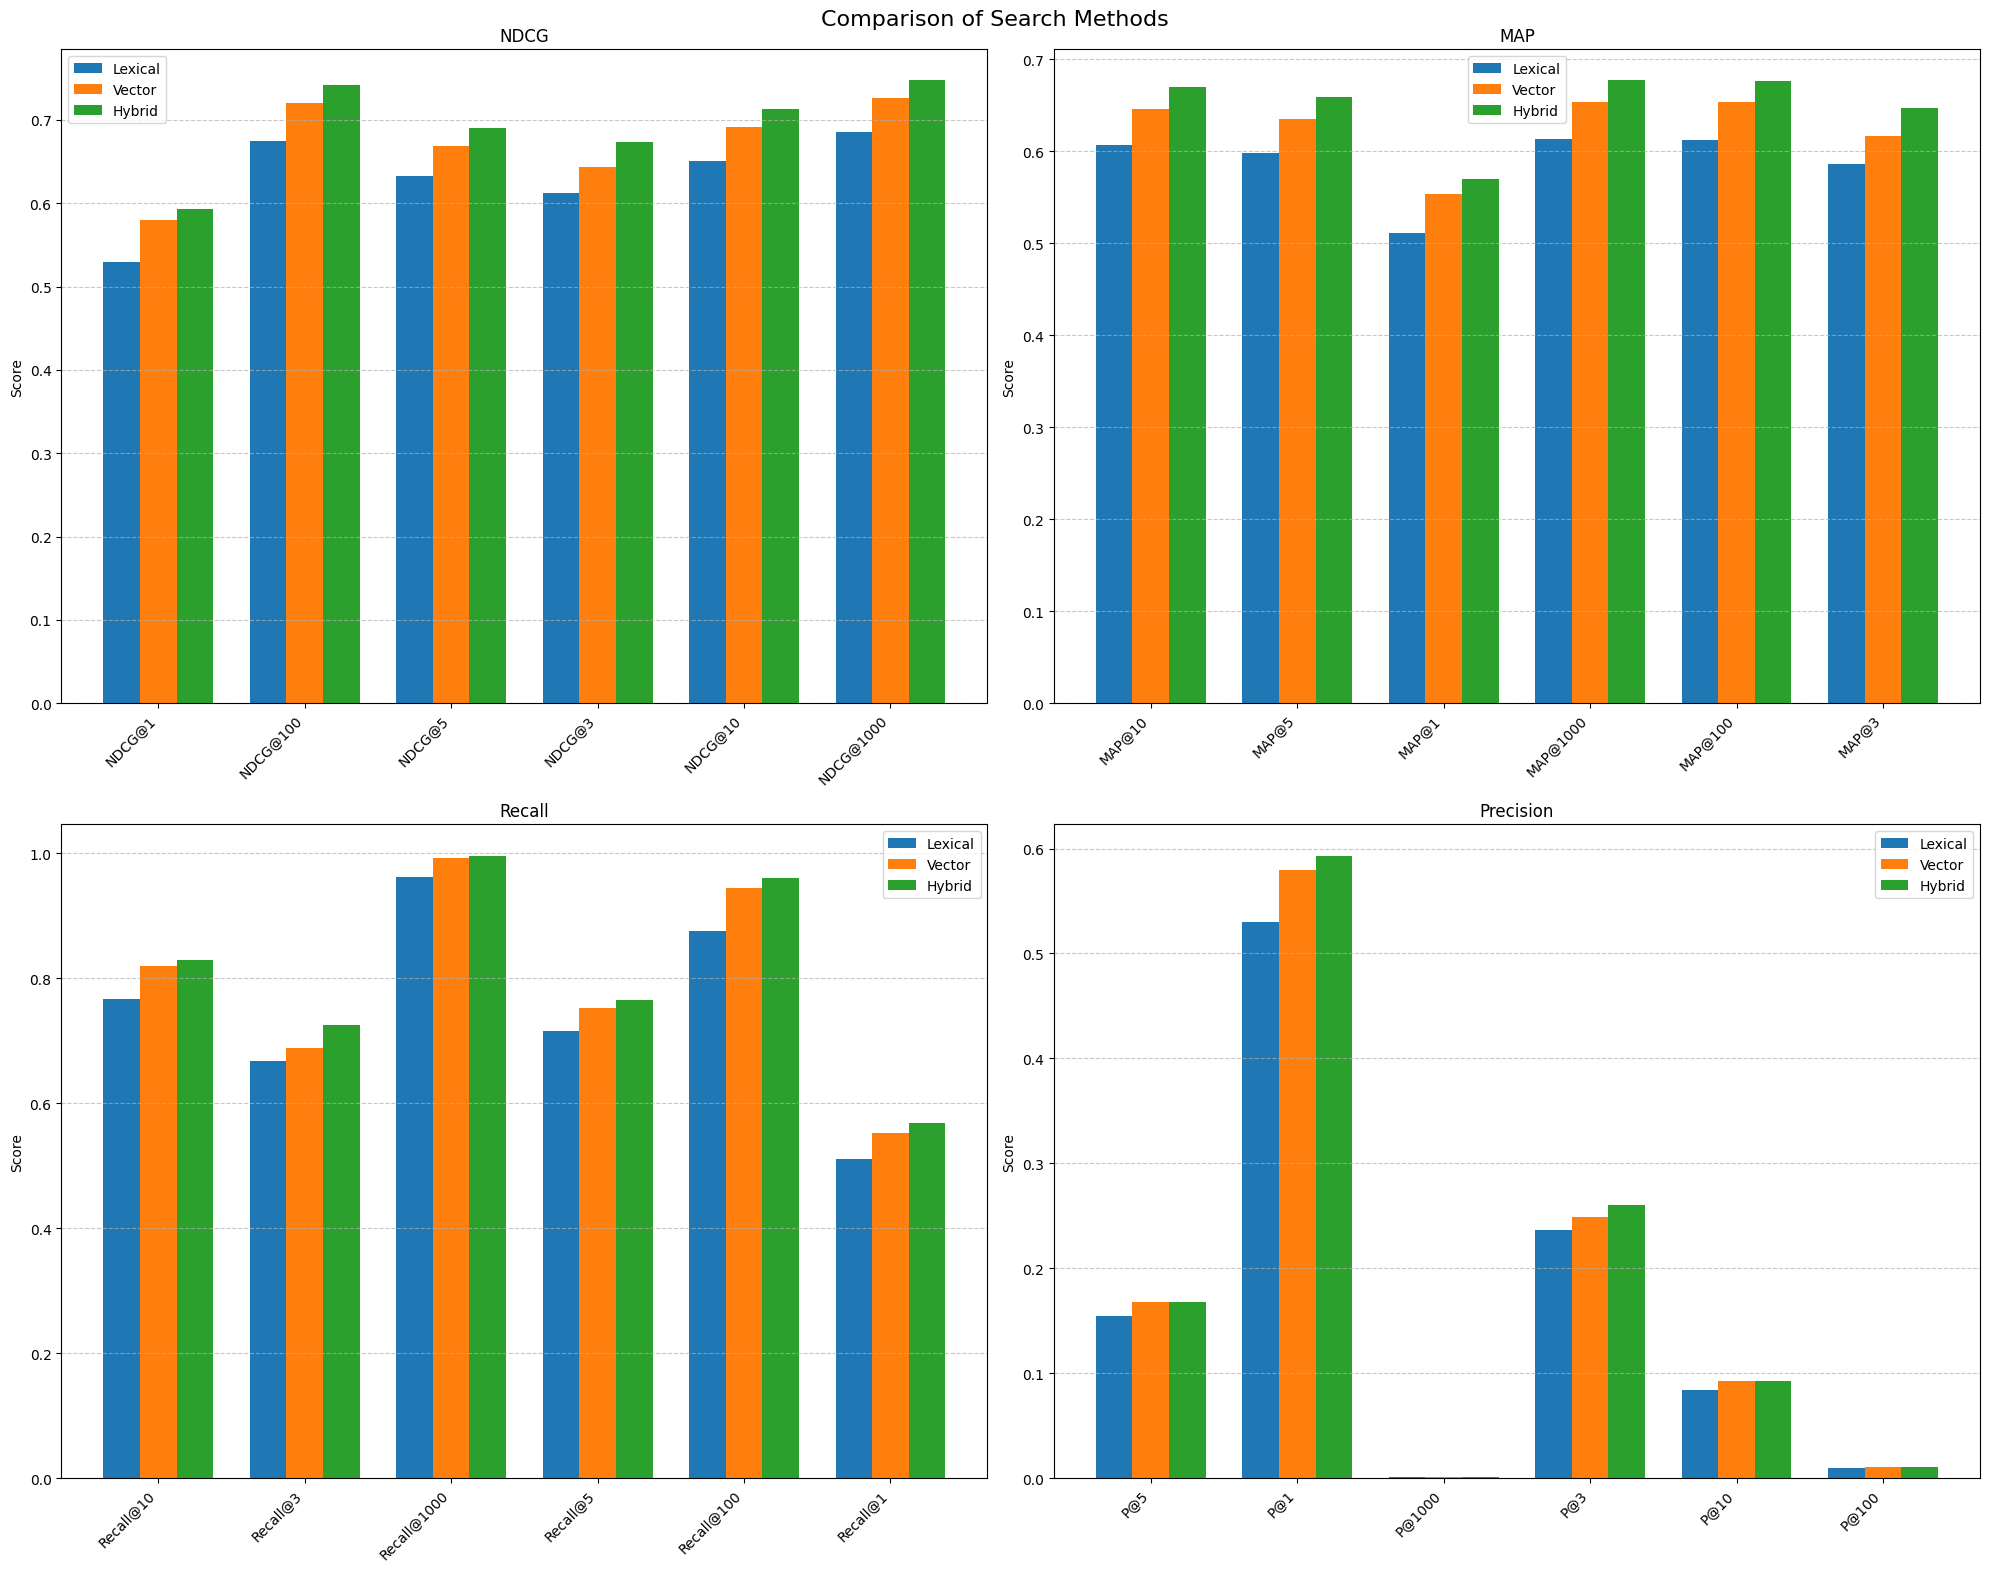

In [ ]:
plot_search_method_comparison(
    lexical_search_metric_dicts,
    vector_search_metric_dicts,
    hybrid_search_metric_dicts,
    metric_names
)

# **Step 10: Storing Evaluation Results In MongoDB**

In [ ]:
from datetime import datetime

def store_evaluation_results(db: Any, search_method: str, metrics: Dict[str, Dict[str, float]], additional_info: Dict[str, Any] = None):
  """
  Store evaluation results in MongoDB.

  Args
  db: MongoDB database instance
  search_method: Name of the search method (e.g., 'lexical', 'vector', 'hybrid')
  metrics: Dictionary containing evaluation metrics (ndcg, map, recall, precision)
  additional_info: Optional dictionary for any additional information to store
  """
  collection = db['evaluation_results']

  # Prepare the document to be inserted
  result_doc = {
      "timestamp": datetime.utcnow(),
      "search_method": search_method,
      "metrics": {}
  }

  # Add metrics to the document
  for metric_name, metric_values in metrics.items():
      result_doc["metrics"][metric_name] = metric_values

  # Add any additional information
  if additional_info:
      result_doc.update(additional_info)

  # Insert the document
  insert_result = collection.insert_one(result_doc)

  print(f"Evaluation results for {search_method} stored with ID: {insert_result.inserted_id}")

In [ ]:
metadata = {
  "dataset_name": DATASET,
  "corpus_size": len(corpus),
  "num_queries": len(queries),
  "num_qrels": sum(len(q) for q in qrels.values())
}

information_retrieval_eval_metrics_list = [
    lexical_search_metric_dicts,
    vector_search_metric_dicts,
    hybrid_search_metric_dicts,
]

# Iterate through metrics list and store evaluation results
for search_method, metrics in zip(information_retrieval_search_methods, information_retrieval_eval_metrics_list):
  store_evaluation_results(db, search_method, metrics, metadata)

# **Evaluating on the Financial Opinion Mining and Question Answering (FIQA) dataset**



---


In [ ]:
DATASET = "fiqa"
corpus, queries, qrels = load_beir_dataset(DATASET)

datasets/fiqa.zip:   0%|          | 0.00/17.1M [00:00<?, ?iB/s]

  0%|          | 0/57638 [00:00<?, ?it/s]

In [ ]:
# print the first item in the corpus
print(list(corpus.items())[0])
print()
# print the first item in the queries
print(list(queries.items())[0])
print()
# print the first item in the qrels
print(list(qrels.items())[0])

('3', {'text': "I'm not saying I don't like the idea of on-the-job training too, but you can't expect the company to do that. Training workers is not their job - they're building software. Perhaps educational systems in the U.S. (or their students) should worry a little about getting marketable skills in exchange for their massive investment in education, rather than getting out with thousands in student debt and then complaining that they aren't qualified to do anything.", 'title': ''})

('8', 'How to deposit a cheque issued to an associate in my business into my business account?')

('8', {'566392': 1, '65404': 1})


In [ ]:
fiqa_corpus = "fiqa_corpus"

In [ ]:
ingest_data(db, corpus=corpus, corpus_collection_name=fiqa_corpus)

Ingested 57638 documents into fiqa_corpus


In [ ]:
setup_vector_search_index_with_filter(db[fiqa_corpus], corpus_vector_search_index_definition)

Error creating new vector search index 'vector_index': Duplicate Index, full error: {'ok': 0.0, 'errmsg': 'Duplicate Index', 'code': 68, 'codeName': 'IndexAlreadyExists', '$clusterTime': {'clusterTime': Timestamp(1726862196, 68), 'signature': {'hash': b'\x05\xa1\x8c\x05\xd4sg\xe7\xfe\x0f\xdcT\x12\x89_=B\xfd\x89=', 'keyId': 7353740577831124994}}, 'operationTime': Timestamp(1726862196, 68)}


In [ ]:
corpus_text_index_definition = {
  "mappings": {
    "dynamic": True,
    "fields": {
      "text": {
        "type": "string"
      }
    }
  }
}

create_collection_search_index(db[fiqa_corpus], corpus_text_index_definition, TEXT_SEARCH_INDEX)

Search index 'text_search_index' created successfully


'text_search_index'

In [ ]:
generate_and_store_embeddings(corpus, db, fiqa_corpus)

Checking for documents without embeddings...


Identifying documents to embed: 100%|██████████| 57638/57638 [00:00<00:00, 133048.67it/s]


Found 56487 documents without embeddings out of 57638 total documents.
Generating embeddings for documents without them...


Embedding documents: 100%|██████████| 56487/56487 [5:25:18<00:00,  2.89it/s]


New embeddings generated and stored successfully.
Total documents with embeddings: 57638


In [ ]:
# Define information retrieval mechanisims

lexical_search = MongoDBSearch(db[fiqa_corpus], "text_search_index")

vector_store = MongoDBAtlasVectorSearch.from_connection_string(
    connection_string=MONGO_URI,
    namespace=f"{DB_NAME}.{fiqa_corpus}",
    embedding=embedding_model,
    index_name="vector_index",
    text_key="text"
)

vector_search = MongoDBVectorSearch(vector_store, embedding_model)

hybrid_search = MongoDBHybridSearch(vector_store, "text_search_index")

In [ ]:
def evaluate_search_method(search_method, method_name):
  retriever = EvaluateRetrieval(search_method, score_function="dot")
  results = retriever.retrieve(corpus, queries)
  metrics = retriever.evaluate(qrels, results, retriever.k_values)

  print("Sample of retrieved results:")
  for query_id, doc_scores in list(results.items())[:5]:
    print(f"Query ID: {query_id}")
    print(f"Query text: {queries[query_id]}")
    print("Top 3 retrieved documents:")
    for doc_id, score in list(doc_scores.items())[:3]:
        print(f"  Doc ID: {doc_id}, Score: {score}")
    print()

  print(f"\nResults for {method_name}:")
  ndcg, _map, recall, precision = metrics
  for metric, values in zip(["NDCG", "MAP", "Recall", "Precision"], [ndcg, _map, recall, precision]):
      print(f"{metric}:")
      for k, v in values.items():
          print(f"  {k}: {v:.4f}")

  # Store results in MongoDB (assuming you've defined this function)
  store_evaluation_results(db, method_name, {
      "ndcg": ndcg,
      "map": _map,
      "recall": recall,
      "precision": precision
  }, {"dataset": "FiQA"})

  return [ndcg, _map, recall, precision]

In [ ]:
# Run evaluations
lexical_search_metric_dicts = evaluate_search_method(lexical_search, "Lexical Search")
vector_search_metric_dicts = evaluate_search_method(vector_search, "Vector Search")
hybrid_search_metric_dicts = evaluate_search_method(hybrid_search, "Hybrid Search")

Sample of retrieved results:
Query ID: 8
Query text: How to deposit a cheque issued to an associate in my business into my business account?
Top 3 retrieved documents:
  Doc ID: 65404, Score: 15.907803535461426
  Doc ID: 318108, Score: 12.162151336669922
  Doc ID: 508754, Score: 11.79505443572998

Query ID: 15
Query text: Can I send a money order from USPS as a business?
Top 3 retrieved documents:
  Doc ID: 420483, Score: 10.010725021362305
  Doc ID: 230003, Score: 9.536849021911621
  Doc ID: 224000, Score: 8.561530113220215

Query ID: 18
Query text: 1 EIN doing business under multiple business names
Top 3 retrieved documents:
  Doc ID: 377152, Score: 10.069451332092285
  Doc ID: 348480, Score: 8.927388191223145
  Doc ID: 203820, Score: 8.656691551208496

Query ID: 26
Query text: Applying for and receiving business credit
Top 3 retrieved documents:
  Doc ID: 176284, Score: 7.173275947570801
  Doc ID: 338406, Score: 6.504555702209473
  Doc ID: 227910, Score: 6.3861494064331055

Query ID

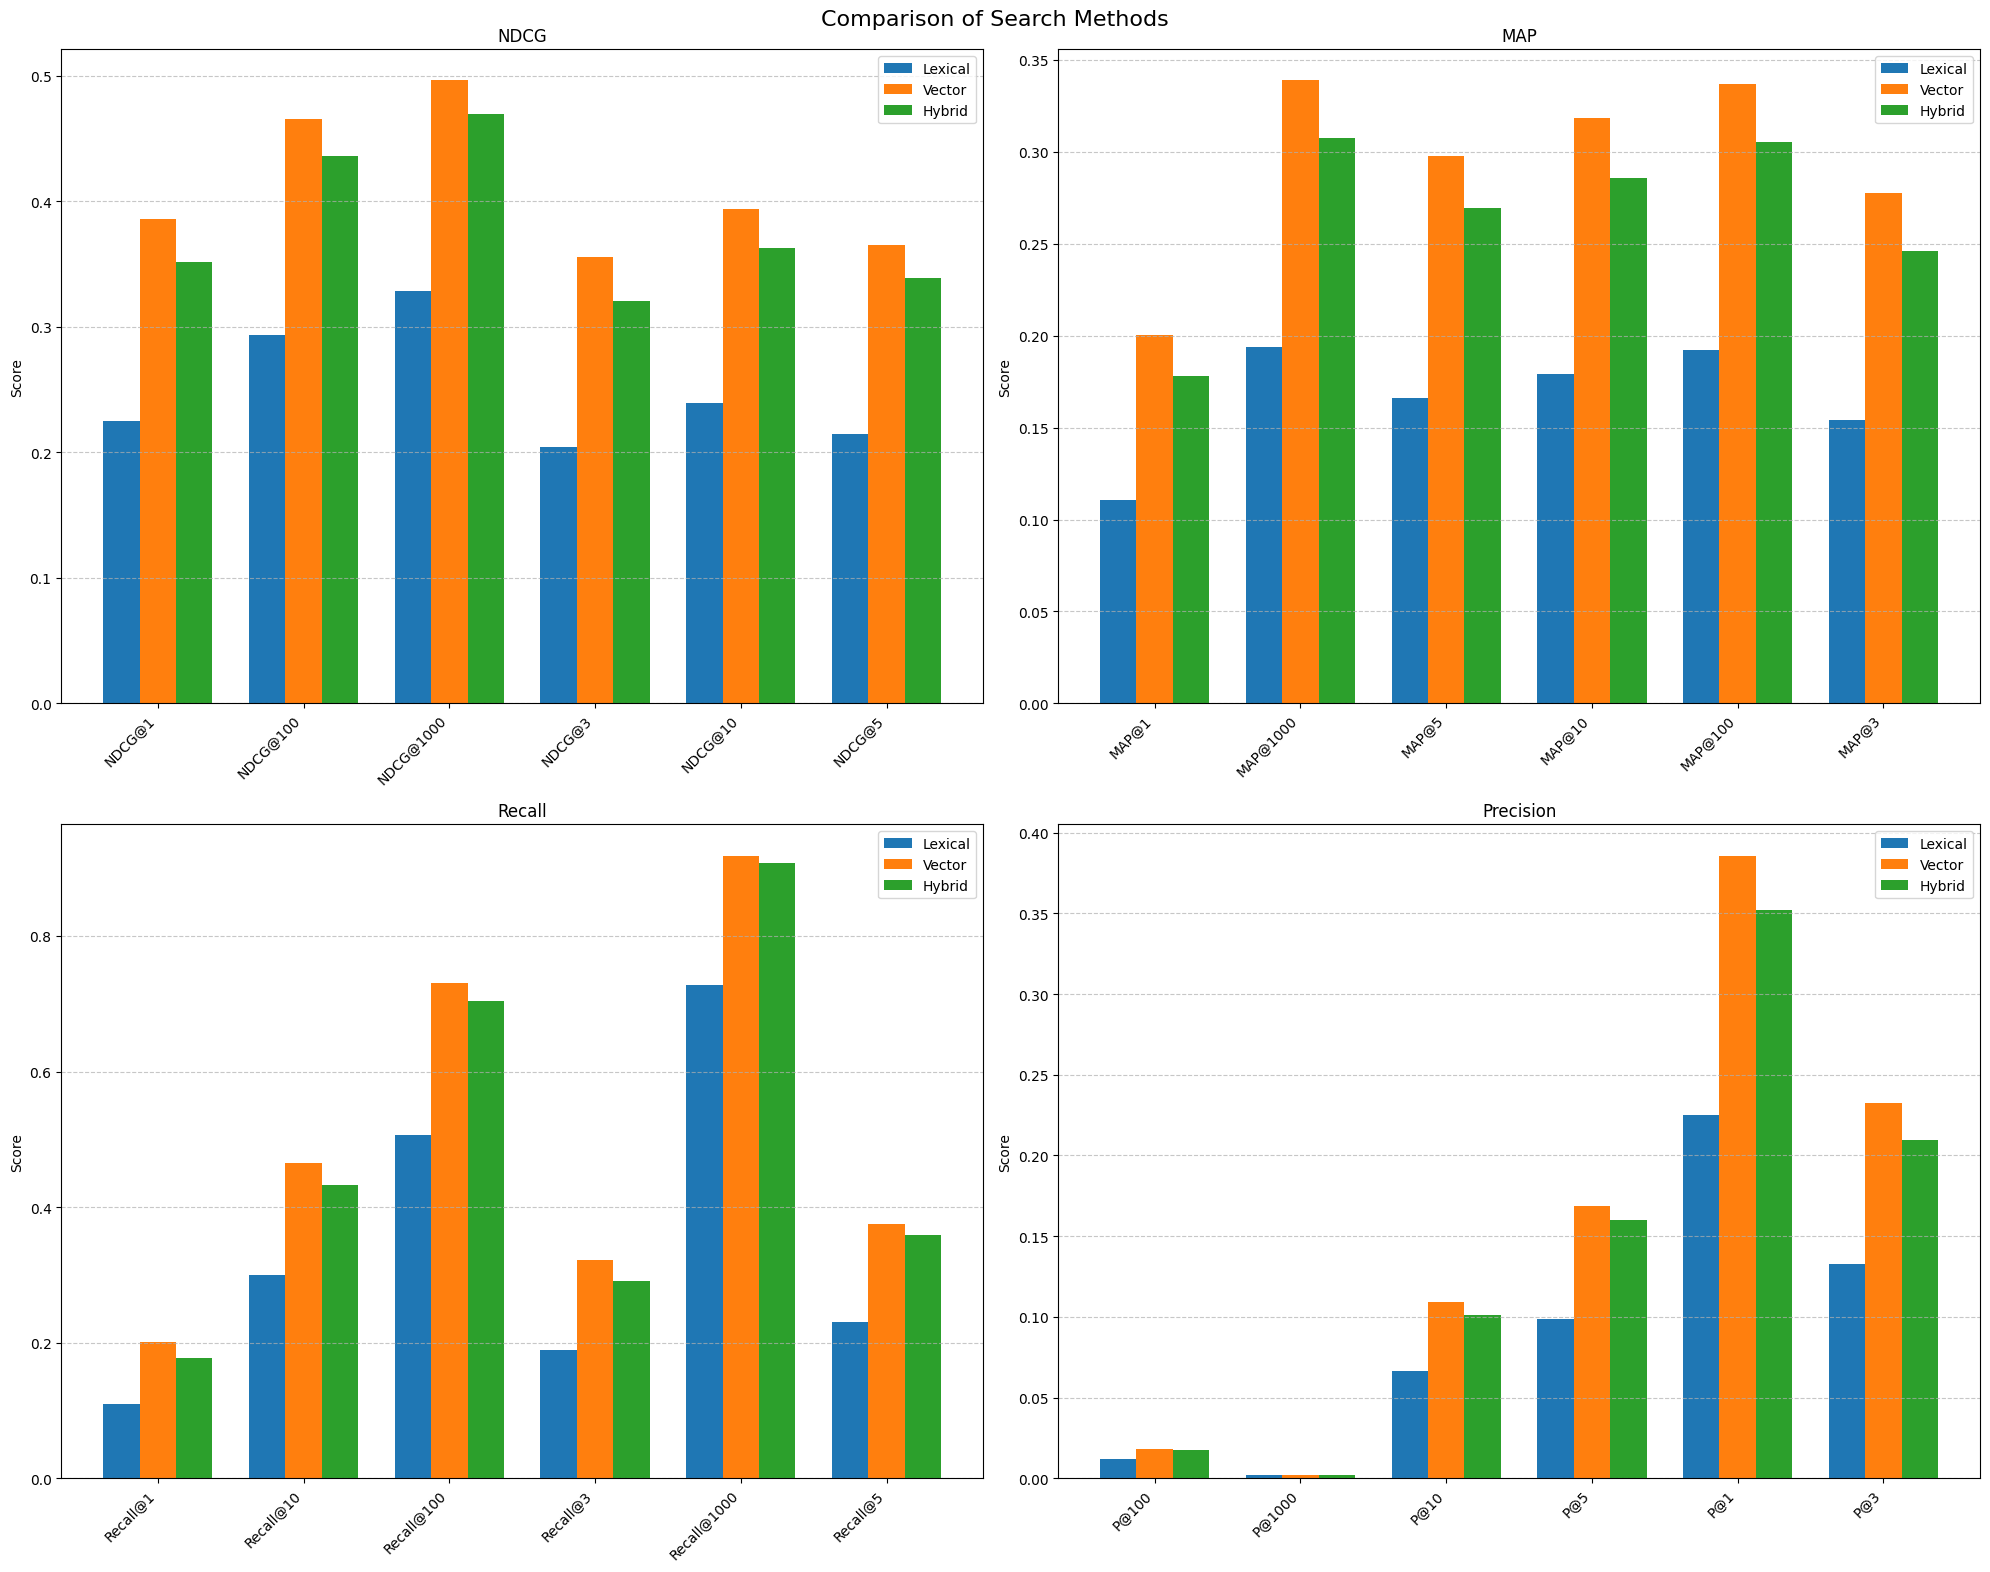

In [ ]:
plot_search_method_comparison(
    lexical_search_metric_dicts,
    vector_search_metric_dicts,
    hybrid_search_metric_dicts,
    metric_names
)